In [101]:
import torch
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from fancyimpute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.path import Path

In [97]:
ALL_BENCHMARKS = ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'GSM8K', 'XWinograd', 'HumanEval']

def load_leaderboard_data(family_name: str = None):
    leaderboard = pd.read_csv('leaderboards/base_llm_benchmark_eval.csv')
    if family_name is not None:
        leaderboard = leaderboard[leaderboard['Model'].str.contains(family_name)]
    return leaderboard


def apply_pca(leaderboard: pd.DataFrame,
              benchmarks: list = ALL_BENCHMARKS,
              n_components: int = 5,
              standardize: bool = True
):
    
    leaderboard_for_pca = leaderboard[benchmarks]

    if standardize:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(leaderboard_for_pca)
    else:
        scaled_data = leaderboard_for_pca


    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)
    principal_df = pd.DataFrame(
        data=principal_components, 
        columns=[f'PC-{i}' for i in range(1, n_components+1)],
        index = leaderboard_for_pca.index
    )
    explained_variance = pca.explained_variance_ratio_
    pca_components = pd.DataFrame(
        pca.components_,
        columns=leaderboard_for_pca.columns,
        index=[f'PC-{i}' for i in range(1, n_components+1)]
    )

    return principal_df, explained_variance, pca_components





def pca_imputation(leaderboard, 
                        benchmarks=ALL_BENCHMARKS, 
                        test_df=None, 
                        n_components=1, 
                        max_iter=1000, 
                        tol=1e-4, 
                        boundary=[0.0, 1.0], 
                        verbose=True):
    """
    Impute missing values in both training and test DataFrames using PCA, 
    with PCA being fitted on the training data only and both DataFrames being refined iteratively until convergence.

    Args:
        train_df: A pandas DataFrame with potential missing values, used to fit PCA.
        test_df: A pandas DataFrame with potential missing values, used to impute missing values using the fitted PCA.
        n_components: Number of principal components to keep.
        max_iter: Maximum number of iterations for convergence.
        tol: Tolerance for stopping criteria.
        boundary: the boundary for the imputed values, if None, no boundary is applied.
    """

    train_df = leaderboard[benchmarks]

    if boundary is not None:
        assert (isinstance(boundary, list) or isinstance(boundary, tuple)) and len(boundary) == 2
    
    # Standardize training data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df)

    # Print ratio of missing values in training data
    if verbose:
        print(f"Missing values in training data: {np.sum(np.isnan(train_scaled)) / train_scaled.size:.2%}")
    
    # Initial imputation for training data
    imputer = SimpleImputer(strategy="mean")
    train_imputed = imputer.fit_transform(train_scaled)
    
    # Iterate to refine imputation on training data
    for _ in range(max_iter):
        pca = PCA(n_components=n_components)
        train_pca = pca.fit_transform(train_imputed)
        train_inverse = pca.inverse_transform(train_pca)

        if np.allclose(train_imputed, train_inverse, atol=tol):
            break

        train_imputed[train_df.isna().values] = train_inverse[train_df.isna().values]

    # Inverse the scaling for training data
    train_final = scaler.inverse_transform(train_imputed)
    if boundary is not None:
        train_final = train_final.clip(boundary[0], boundary[1])

    train_final_df = pd.DataFrame(train_final, columns=leaderboard[benchmarks].columns, index=leaderboard[benchmarks].index)

    # Apply the fitted transformations to the test data
    if test_df is not None:
        # Prepare test data using the same scaler and imputer as the training data
        test_scaled = scaler.transform(test_df)

        if verbose:
            # Print ratio of missing values in test data
            print(f"Missing values in test data: {np.sum(np.isnan(test_scaled)) / test_scaled.size:.2%}")

        # Initial imputation for test data
        test_imputed = imputer.transform(test_scaled)

        # Iterate to refine imputation on test data
        for _ in range(max_iter):
            test_pca = pca.transform(test_imputed)
            test_inverse = pca.inverse_transform(test_pca)

            if np.allclose(test_imputed, test_inverse, atol=tol):
                break

            test_imputed[test_df.isna().values] = test_inverse[test_df.isna().values]

        # Inverse the scaling for test data
        test_final = scaler.inverse_transform(test_imputed)
        if boundary is not None:
            test_final = test_final.clip(boundary[0], boundary[1])
        test_final_df = pd.DataFrame(test_final, columns=test_df.columns, index=test_df.index)
    else:
        test_final_df = None
    
    return train_final_df, test_final_df


def plot_pca_explained_variance(explained_variance: list):
    """ Plots the explained variance of each principal component.
    Corresponds to Figure 2(a).
    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.bar(range(1, len(explained_variance)+1), explained_variance)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Explained Variance of Principal Components')

    top_3_variance_sum = sum(explained_variance[:3])
    print(f'Top 3 components explain {top_3_variance_sum:.3f} of the variance')

    brace_height = explained_variance[0] + 0.05
    brace_x_start = 1 - 0.4
    brace_x_end = 3 + 0.4

    vertices = [
        (brace_x_start, brace_height),  # Left bottom of the brace
        (brace_x_start, brace_height + 0.01),  # Left top of the brace
        (brace_x_end, brace_height + 0.01),  # Right top of the brace
        (brace_x_end, brace_height),  # Right bottom of the brace
    ]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO]

    path = Path(vertices, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1.5, edgecolor='gray')
    ax.add_patch(patch)
    ax.annotate(f"{top_3_variance_sum:.3f}", 
                ((brace_x_start + brace_x_end) / 2, brace_height+0.02),
                textcoords="data",
                ha="center", va="bottom", fontsize=11)
    ax.set_ylim([0.0, 1.0])
   
    return


def plot_pca_weights(pca_components: pd.DataFrame):
    plt.figure(figsize=(6, 3))
    sns.heatmap(pca_components, annot=True, fmt='.2f', cmap='coolwarm', cbar=False)
    plt.title('Principal Component Weights')
    plt.xticks(rotation=30)

    return 




Missing values in training data: 7.59%
Top 3 components explain 0.967 of the variance


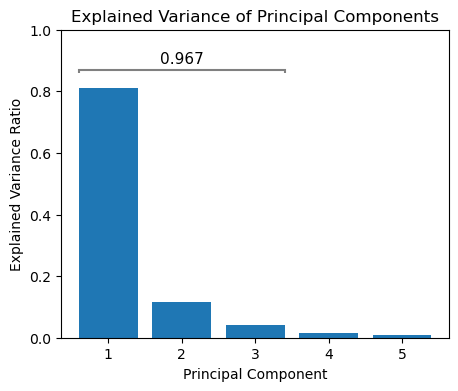

In [93]:
leaderboard = load_leaderboard_data()
imputed_metric_df, _ = pca_imputation(leaderboard)
principal_df, explained_variance, pca_components = apply_pca(imputed_metric_df, n_components=5, standardize=False)
plot_pca_explained_variance(explained_variance)

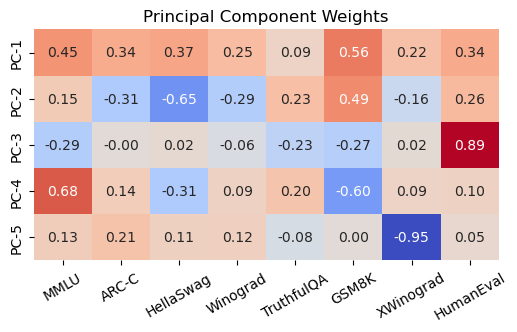

In [98]:
plot_pca_weights(pca_components)

In [99]:
leaderboard

,Model,Model Family,Model Size (B),Pretraining Data Size (T),FLOPs (1E21),MMLU,ARC-C,HellaSwag,Winograd,TruthfulQA,GSM8K,XWinograd,HumanEval
0,meta-llama/Llama-2-7b-hf,Llama-2,7.0,2.000,84.000,0.437961,0.530717,0.777435,0.740331,0.389802,0.144807,0.754881,0.128049
1,meta-llama/Llama-2-13b-hf,Llama-2,13.0,2.000,156.000,0.543378,0.581058,0.809699,0.766377,0.341724,0.228203,0.786798,0.182927
2,meta-llama/Llama-2-70b-hf,Llama-2,70.0,2.000,840.000,0.698321,0.673208,0.873332,0.837411,0.449235,0.540561,0.824453,0.298780
3,huggyllama/llama-7b,Llama,6.7,1.000,40.200,0.356933,0.509386,0.778132,0.714286,0.343279,0.080364,0.693204,0.128049
4,huggyllama/llama-13b,Llama,13.0,1.000,78.000,0.476106,0.561433,0.809201,0.762431,0.394789,0.075815,0.730362,0.158537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,togethercomputer/RedPajama-INCITE-Base-3B-v1,RedPajama-INCITE-Base,3.0,0.800,14.400,0.270279,0.401877,0.647680,0.647198,0.332349,0.012889,NaN,NaN
103,togethercomputer/RedPajama-INCITE-Base-7B-v0.1,RedPajama-INCITE-Base,7.0,1.000,42.000,0.276821,0.462457,0.716292,0.673244,0.330348,0.015921,NaN,NaN
104,LLM360/Amber,Amber,7.0,1.259,52.878,0.268357,0.409556,0.737901,0.678769,0.335564,0.028052,NaN,NaN
105,Salesforce/codegen-6B-nl,Codegen,6.0,0.360,12.960,0.259345,0.423208,0.685919,0.664562,0.344705,0.021986,NaN,NaN


In [ ]:
def correlation_pc_log_compute(leaderboard: pd.DataFrame
):
    
    compute = leaderboard['FLOPs (1E21)']
    log_compute = np.log10(compute)
    
